<a href="https://colab.research.google.com/github/IbrahimEnouali/Arabic-Text-Classification-Using-Bert/blob/main/TextClassificationModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install transformers

In [ ]:
import pandas as pd
import torch
import numpy as np
import sklearn
import transformers
from transformers import  AutoModel,AutoTokenizer
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from torchsummary import summary

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/S2D Project/'

In [ ]:
df = pd.read_csv(path+'preprocessed_data.csv')

In [ ]:
from sklearn.model_selection import train_test_split
#Split to train and test
random_seed = 42
df_train, temp_df = train_test_split(
    df,
    test_size=0.4,
    shuffle=True,
    stratify=df.Label,
    random_state=random_seed
)
df_valid, df_test = train_test_split(
    temp_df,
    test_size=0.5,
    shuffle=True,
    random_state=random_seed
)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
arabert_model = 'aubmindlab/bert-base-arabertv02' #Bert model we will use to encode arabic addresses
tokenizer = AutoTokenizer.from_pretrained(arabert_model)
model = AutoModel.from_pretrained(arabert_model).to(device)

In [ ]:
#Create customized dataset
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
  def __init__(self, df, tokenizer, model, max_length, device):
    self.df = df
    self.tokenizer = tokenizer
    self.model = model
    self.max_length = max_length
    self.device = device

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    address = self.df.iloc[index]['Address']
    label = self.df.iloc[index]['Label']

    inputs = self.tokenizer(
        address,
        padding='max_length',
        max_length=self.max_length,
        truncation=True,
        return_tensors='pt'
    ).to(self.device)
    with torch.no_grad():
      outputs = self.model(**inputs)
    cls_embedding = outputs.last_hidden_state[:,0,:]

    return cls_embedding.view(-1), label

In [ ]:
train_dataset = CustomDataset(df_train, tokenizer, model, max_length=30, device=device)
valid_dataset = CustomDataset(df_valid, tokenizer, model, max_length=30, device=device)
test_dataset = CustomDataset(df_test, tokenizer, model, max_length=30, device=device)

In [ ]:
n_train = len(train_dataset)
n_valid = len(valid_dataset)

In [ ]:
batch_size = 64
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Logistic Regression


In [ ]:
import torch.nn as nn
import torch.optim as optim


class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size):
      super().__init__()
      self.l = nn.Linear(input_size, 1)
      self.a = nn.Sigmoid()

    def forward(self, x):
      x = self.l(x)
      return self.a(x)

    def predict(self, x):
      output = self.forward(x)
      return (output>=0.5).float()

In [ ]:
summary(dnn_classifier,(1,768))

In [ ]:
# Initialize the logistic regression model
input_size = 768
logistic_model = LogisticRegressionModel(input_size).to(device)

# Define loss function and optimizer
criterion = nn.BCELoss().to(device)  # Binary cross-entropy loss
optimizer = optim.SGD(logistic_model.parameters(), lr=0.01)

In [ ]:
def train(model, num_epochs, train_dl, valid_dl, device):
  loss_hist_train = [0]*num_epochs
  loss_hist_valid = [0]*num_epochs
  accuracy_hist_train = [0]*num_epochs
  accuracy_hist_valid = [0]*num_epochs
  for epoch in range(num_epochs):
    # Training
    model.train()
    for cls_embeddings, labels in train_dl:
      labels = labels.float().view(-1, 1).to(device)
      #Forward propagation
      outputs = model(cls_embeddings)
      #Compute loss
      loss = criterion(outputs, labels)
      #Back propagation
      loss.backward()
      #Update weigths
      optimizer.step()
      optimizer.zero_grad()
      loss_hist_train[epoch] += loss.item()
      is_correct = ((outputs>=0.5).float() == labels).float()
      accuracy_hist_train[epoch] += is_correct.mean()
    loss_hist_train[epoch] /= n_train/batch_size
    accuracy_hist_train[epoch] /= n_train/batch_size
    # Validaton
    model.eval()
    with torch.no_grad():
      for cls_embeddings, labels in valid_dl:
        labels = labels.float().view(-1, 1).to(device)
        outputs = model(cls_embeddings)
        loss = criterion(outputs, labels)
        loss_hist_valid[epoch] += loss.item()
        is_correct = ((outputs>=0.5).float() == labels).float()
        accuracy_hist_valid[epoch] += is_correct.mean()
    loss_hist_valid[epoch] /= n_valid/batch_size
    accuracy_hist_valid[epoch] /= n_valid/batch_size
    # Print the loss at the end of each epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {loss_hist_train[epoch]:.4f} - Valid Loss: {loss_hist_valid[epoch]:.4f} ')
    print(f'Epoch [{epoch + 1}/{num_epochs}] - Train Accuracy: {accuracy_hist_train[epoch]:.4f} - Valid Accuracy: {accuracy_hist_valid[epoch]:.4f} ')
    # Save model at each iteration
    torch.save(model.state_dict(), 'model_checkpoint.pth')
  return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

In [ ]:
history = train(logistic_model, 1, train_dl, valid_dl, device=device)

In [ ]:
loss_hist_train = [0.3069, 0.2606, 0.2503, 0.2452]
loss_hist_valid = [0.2630, 0.2492, 0.2657, 0.2549]
accuracy_hist_train = [0.8718, 0.8950, 0.8998, 0.9025]
accuracy_hist_valid = [0.8945, 0.9011, 0.8903, 0.8963]
history = loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

Text(0.5, 0, 'Epochs')

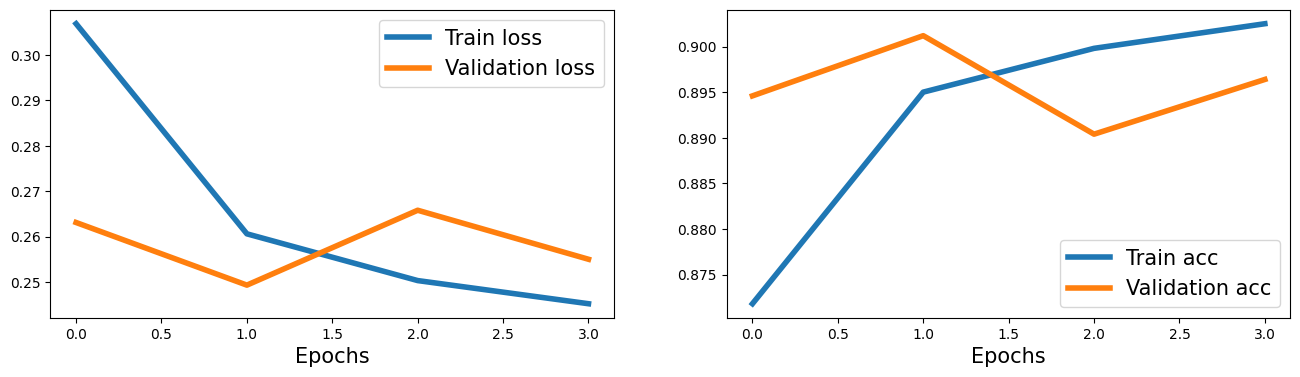

In [ ]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)
ax = fig.add_subplot(1, 2, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(['Train acc', 'Validation acc'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

In [ ]:
# Test function in order to see how the model did on unseen data
def test(model, test_dl, device):
  y_true = []
  y_pred = []
  model.eval()
  with torch.no_grad():
    for cls_embeddings, labels in test_dl:
      labels = labels.float().view(-1, 1).to(device)
      pred = model.predict(cls_embeddings)
      y_true.extend(labels.cpu().numpy())
      y_pred.extend(pred.cpu().numpy())

  return np.array(y_true), np.array(y_pred)

## Error Analysis for Epoch 1

In [ ]:
logistic_model.load_state_dict(torch.load('model_checkpoint_epoch_1.pth'))

<All keys matched successfully>

In [ ]:
y_true, y_pred = test(logistic_model, test_dl, device)

In [ ]:
confusion = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.84      0.88     26523
         1.0       0.87      0.93      0.90     30003

    accuracy                           0.89     56526
   macro avg       0.89      0.89      0.89     56526
weighted avg       0.89      0.89      0.89     56526



<Axes: >

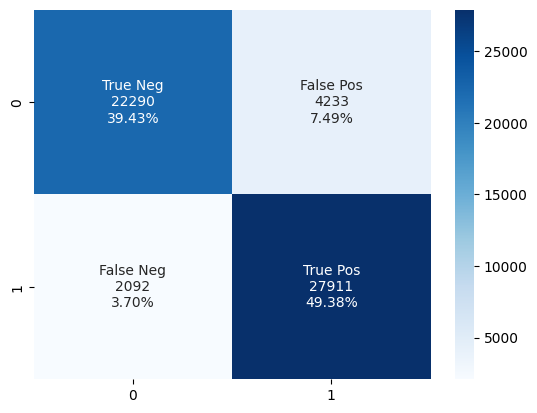

In [ ]:
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in confusion.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in confusion.flatten()/np.sum(confusion)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(confusion, annot=labels, fmt="", cmap='Blues')

## Error Analysis for Epoch 2



In [ ]:
logistic_model.load_state_dict(torch.load('model_checkpoint_epoch_2.pth'))

<All keys matched successfully>

In [ ]:
y_true, y_pred = test(logistic_model, test_dl, device)

In [ ]:
confusion = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.85      0.88     26523
         1.0       0.88      0.93      0.90     30003

    accuracy                           0.89     56526
   macro avg       0.90      0.89      0.89     56526
weighted avg       0.90      0.89      0.89     56526



<Axes: >

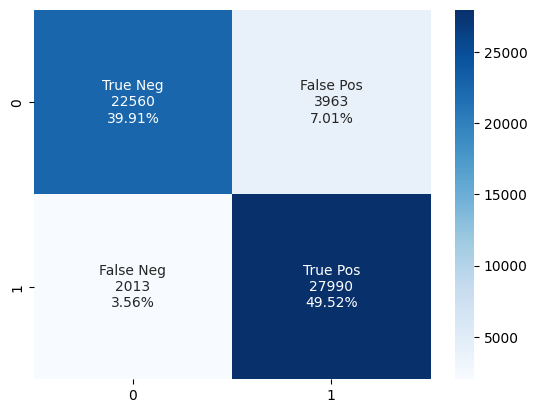

In [ ]:
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in confusion.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in confusion.flatten()/np.sum(confusion)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(confusion, annot=labels, fmt="", cmap='Blues')

## Error Analysis for Epoch 3

In [ ]:
logistic_model.load_state_dict(torch.load('model_checkpoint_epoch_3.pth'))

<All keys matched successfully>

In [ ]:
y_true, y_pred = test(logistic_model, test_dl, device)

In [ ]:
confusion = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.80      0.87     26523
         1.0       0.85      0.96      0.90     30003

    accuracy                           0.88     56526
   macro avg       0.89      0.88      0.88     56526
weighted avg       0.89      0.88      0.88     56526



<Axes: >

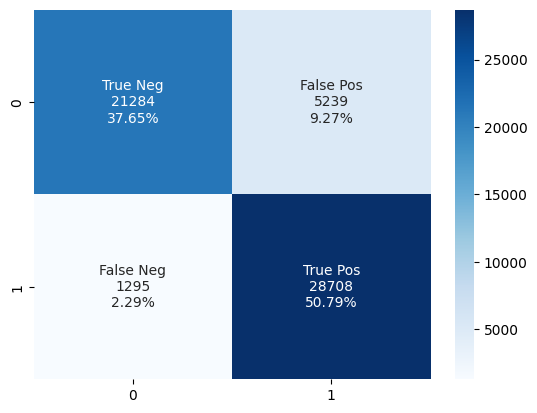

In [ ]:
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in confusion.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in confusion.flatten()/np.sum(confusion)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(confusion, annot=labels, fmt="", cmap='Blues')

## Error Analysis for Epoch 4

In [ ]:
logistic_model.load_state_dict(torch.load('model_checkpoint_epoch_4.pth'))

<All keys matched successfully>

In [ ]:
y_true, y_pred = test(logistic_model, test_dl, device)

In [ ]:
confusion = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.82      0.87     26523
         1.0       0.86      0.95      0.90     30003

    accuracy                           0.89     56526
   macro avg       0.90      0.89      0.89     56526
weighted avg       0.89      0.89      0.89     56526



<Axes: >

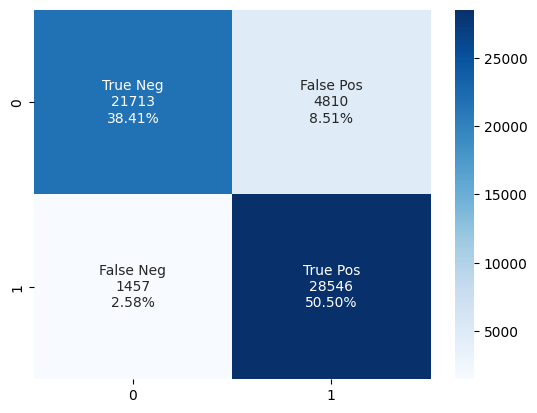

In [ ]:
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in confusion.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in confusion.flatten()/np.sum(confusion)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(confusion, annot=labels, fmt="", cmap='Blues')

# Deep Neural Network

In [ ]:
class DNN(nn.Module):
    def __init__(self, input_size):
      super().__init__()
      l1 = nn.Linear(input_size, 384)
      a1 = nn.ReLU()
      l2 = nn.Linear(384, 40)
      a2 = nn.ReLU()
      dropout = nn.Dropout(p=0.5)
      l3 = nn.Linear(40, 1)
      a3 = nn.Sigmoid()
      l = [l1, a1, l2, a2, dropout, l3, a3]
      self.module_list = nn.ModuleList(l)

    def forward(self, x):
      for f in self.module_list:
        x = f(x)
      return x

    def predict(self, x):
      outputs = self.forward(x)
      return (outputs>=0.5).float()

In [ ]:
# Initialize the logistic regression model
input_size = 768
dnn_classifier = DNN(input_size).to(device)

# Define loss function and optimizer
criterion = nn.BCELoss().to(device)  # Binary cross-entropy loss
optimizer = optim.SGD(dnn_classifier.parameters(), lr=0.01)

In [ ]:
history_nn = train(dnn_classifier, 1, train_dl, valid_dl, device)

Epoch [1/1] - Train Loss: 0.2676 - Valid Loss: 0.2318 
Epoch [1/1] - Train Accuracy: 0.8963 - Valid Accuracy: 0.9074 


In [ ]:
loss_hist_train = [0.3596, 0.2817, 0.2676]
loss_hist_valid = [0.2601, 0.2405, 0.2318]
accuracy_hist_train = [0.8505, 0.8906, 0.8963]
accuracy_hist_valid = [0.8950, 0.9039, 0.9074]
history = loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

Text(0.5, 0, 'Epochs')

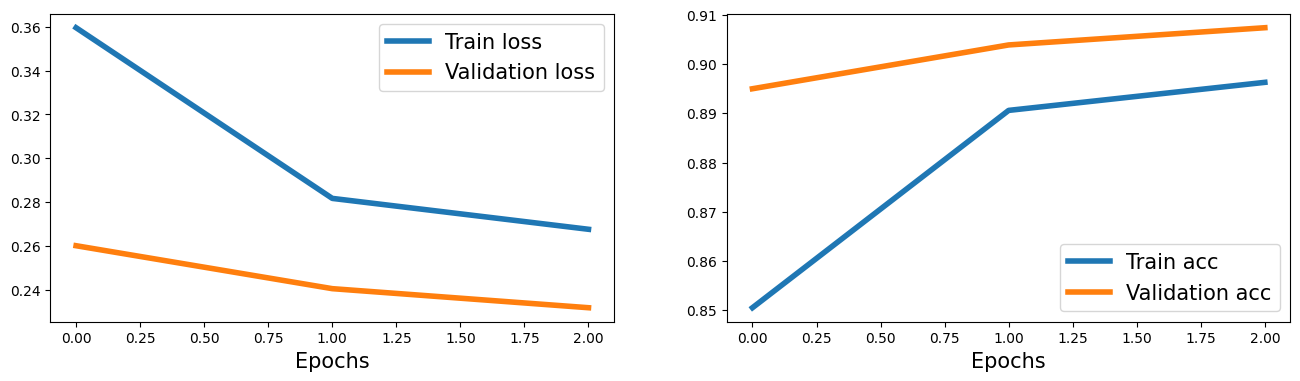

In [ ]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)
ax = fig.add_subplot(1, 2, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(['Train acc', 'Validation acc'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

In [ ]:
y_true, y_pred = test(dnn_classifier, test_dl, device)

In [ ]:
confusion = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.90      0.90     26523
         1.0       0.91      0.91      0.91     30003

    accuracy                           0.90     56526
   macro avg       0.90      0.90      0.90     56526
weighted avg       0.90      0.90      0.90     56526



<Axes: >

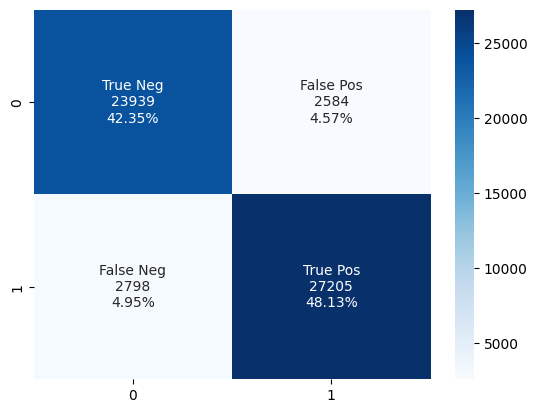

In [ ]:
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in confusion.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in confusion.flatten()/np.sum(confusion)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(confusion, annot=labels, fmt="", cmap='Blues')